# Libraries

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
from matplotlib.animation import FuncAnimation

# Ising model

The Ising model describes magnetic dipoles in one of two states, either +1 or -1. These spins are arranged in a graph, typically a lattice, where each spin can interact with its neighbouring spins. The total energy of the system in $\alpha_k$ state is the expectation value of the sum of individual potentials:$$E_{\alpha_k} = - J \sum_{\braket{i,j}}s_{i}s_{j},$$where J is called the exchange energy and is a measure of the strength of the spin–spin interaction. The alignment of spins in equilibrium depends on the sign of the exchange energy, J. If J is greater than zero, neighbouring spins tend to align in the lowest energy state. The ground state will be a ferromagnet at low temperatures, with all spins aligned. If J is less than zero, neighbouring spins tend to have opposite alignment in the lowest energy state. The ground state will be an antiferromagnet at low temperatures, with alternating spins.

# Metropolis algorithm:

The algorithm is initialised with a fixed state ($\alpha_j$) of a given temperature and spin configuration and runs until a thermal equilibrium is reached. Continued application produces a statistical fluctuation from which thermodynamic properties can be devised. The method is made up of the following main steps:
1. The algorithm takes the current state $\alpha_j$.
2. Generates a new condition $\alpha_i$, by flipping a random spin in the system.
3. Calculates the energies of the current condition $E_j$ and the new condition $E_i$
    - if $E_j \leq E_i$: The new configuration is accepted as the new state of the system
    - if $E_j > E_i$: The new configuration is accepted as the new state with a probability of $P = \exp(-\Delta E/k_BT)$
4. Return to step 1.

An inherent problem of this method is that because of the 2N possible configurations of the system computing time can be significant.

# The 2D Ising Chain

# Algorithms

In [31]:
def LatticeEnergy(lattice = np.array):
    "A function to calculate the energy of a given lattice state"
    neigbours = generate_binary_structure(2, 1) 
    neigbours[1][1] = False
    spin_energies = -lattice * convolve(lattice, neigbours, mode='constant', cval=0)
    return spin_energies.sum()

def InitialState(N = int, percentage = int):
    "The algorithm creates a 2D spin lattice system with a percentage of how many spins should be up"
    random_values = np.random.random((N,N)) # random values between 0 and 1
    lattice = np.zeros((N, N)) # A grid of zeros
    lattice[random_values>=percentage] = 1 
    lattice[random_values<percentage] = -1
    return lattice

def MetropolisAlgorithm(N = int, percentage = float, times = int, BJ = float):
    "An algorithm that runs the Metropolis simulation on a spin system"
    # Generating the initial state
    current_lattice = InitialState(N, percentage) 
    energy = LatticeEnergy(current_lattice)
    
    # Arrays that contain the total energy and spin of the system at given time steps
    spin_evolution = np.zeros(times-1)
    energy_evolution = np.zeros(times-1)
    state_evolution = [current_lattice.copy(),]
    
    # State of the system
    #current_lattice = starting_lattice.copy()
    
    for t in range(0,times-1):
        # 2. pick random point on array and flip spin
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = current_lattice[x,y] #initial spin
        spin_j = spin_i*-1 #proposed spin flip
        
        # Compute the change of the system energy
        E_i = 0
        E_j = 0
        if x > 0:
            E_i += -spin_i*current_lattice[x-1,y]
            E_j += -spin_j*current_lattice[x-1,y]
        if x < N-1:
            E_i += -spin_i*current_lattice[x+1,y]
            E_j += -spin_j*current_lattice[x+1,y]
        if y > 0:
            E_i += -spin_i*current_lattice[x,y-1]
            E_j += -spin_j*current_lattice[x,y-1]
        if y < N-1:
            E_i += -spin_i*current_lattice[x,y+1]
            E_j += -spin_j*current_lattice[x,y+1]
        
        # Change the state according to the change of energy
        dE = E_j-E_i
        if (dE > 0)*(np.random.random() < np.exp(-BJ*dE)):
            current_lattice[x,y]=spin_j
            energy += dE
            state_evolution.append(current_lattice)
        elif dE <= 0:
            current_lattice[x,y]=spin_j
            energy += dE
            state_evolution.append(current_lattice)
            
        spin_evolution[t] = current_lattice.sum()
        energy_evolution[t] = energy
        #state_evolution.append(current_lattice)
            
    return spin_evolution, energy_evolution, state_evolution

## Simulation

In [49]:
N = 50
spins, energies, states = MetropolisAlgorithm(N, 0.75, 200000, 0.7)

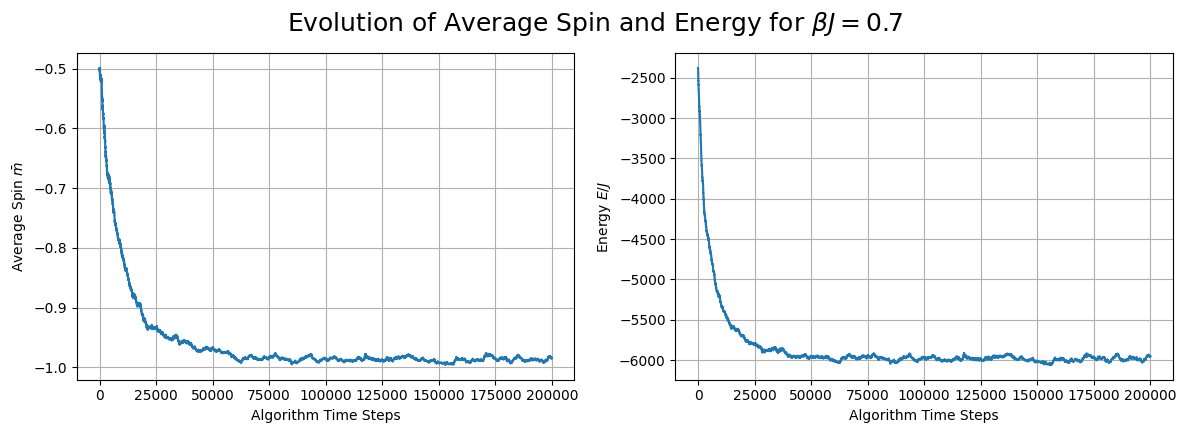

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy for $\beta J=$0.7', y=1.07, size=18)
plt.show()

In [51]:
states[-1]

array([[ 1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

MovieWriter imagemagick unavailable; using Pillow instead.


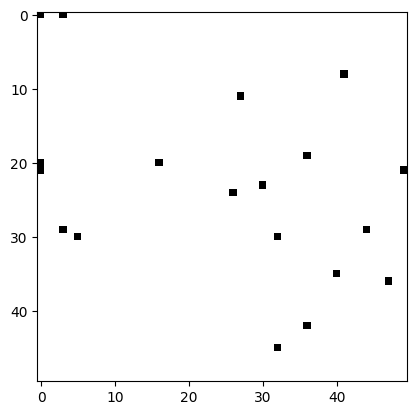

In [59]:
# Function to update the imshow plot at each frame
def update(frame, states, im):
    # Get the state for the current frame
    state = states[frame]
    
    # Update the imshow plot with the new state
    im.set_array(state)
    
    return [im]

fig, ax = plt.subplots()
im = ax.imshow(states[0], cmap='binary', interpolation='none')

# Set up the animation
animation = FuncAnimation(fig, update, fargs=(states, im), frames=len(states), interval=50, blit=True)
animation.save('lattice_animation.gif', writer='imagemagick')
# Show the animation
plt.show()

In [ ]:
len(states)

10